In [21]:
import nibabel as nib
import os
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

base_dir = '/Volumes/camille/IBMA_simu/'

nrep = 38; # 38 repeats are available
nsimuperrep = 30*30*30
nreal = nrep*nsimuperrep

tau2 = 1
kstudies = 25
dof = kstudies - 1



In [23]:
wth_n20 = dict()
hat_taus = dict()
zstats = dict()
meta_copes = dict()
meta_varcopes = dict()
for wth in ['05', '10', '20', '40', '80', 'diff']:
    hat_taus[wth] = []
    zstats[wth] = []
    meta_copes[wth] = []
    meta_varcopes[wth] = []
    for r in range(1, nrep+1):
        wth_n20[wth, r] = os.path.join(
            base_dir, 
            'test1_k025_n20_btw1_wth' + wth + '_nominal', 
            '{num:04d}'.format(num=r), # Repeat
            'megaMFX/')

for [wth, r], folder in wth_n20.items():
    data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'mean_random_effects_var1.nii.gz')).get_data().flatten()
    hat_taus[wth] = np.append(hat_taus[wth], data_array)
    z_data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'zstat1.nii.gz')).get_data().flatten()
    zstats[wth] = np.append(zstats[wth], z_data_array)
    varcope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'varcope1.nii.gz')).get_data().flatten()
    meta_varcopes[wth] = np.append(meta_varcopes[wth], varcope_array)


In [24]:
p_uppers = dict()
p_lowers = dict()

# Pre-computed confidence interval for QQplots for more effeciency
data_sizes = [27000, nreal]
for d in data_sizes:
    x_log_spaced = np.logspace(np.log10(1), np.log10(d), num=500, endpoint=False)
    x_log_spaced = np.append(x_log_spaced,d) # Manually add endpoint to avoid rounding errors
    
    p_uppers[int(d)] = (
        [t/d for t in x_log_spaced],
        [scipy.stats.beta.ppf(0.025, t, d-t+1) for t in x_log_spaced]
    )
    p_lowers[int(d)] = (
        [t/d for t in x_log_spaced],
        [scipy.stats.beta.ppf(0.975, t, d-t+1) for t in x_log_spaced]
    )

In [25]:
def distribution_plot(title, data, dist, *args, **kwargs):
    np.random.seed(0)
    num_bins = 100
    

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10,5))

    # histogram plot
    n, bins, patches = ax1.hist(data, num_bins, normed=True)

#     # fit distribution and estimate parameters
#     param = dist.fit(data)
#     print(param)
#     y = dist.pdf(bins, *param[:-2], loc=param[-2], scale=param[-1])
    
    # known distribution
    y = dist.pdf(bins, *args)
    
    ax1.plot(bins, y, '-')
    ax1.set_title(title)
    
    # qq-plot plot
    p_th = [t/data.size for t in range(1,data.size+1)]

    line1, = ax2.loglog(p_th, sorted(dist.sf(data, *args)), '.', linewidth=1,
                     label=title, markersize=3)
    ax2.plot(p_th, p_th, '-')
    x, p_upper = p_uppers[int(data.size)]
    ax2.plot(x, p_upper, 'c-')
    x, p_lower = p_lowers[int(data.size)]
    ax2.plot(x, p_lower, 'c-')   
    ax2.set_title('Q-Q plot')


    ax2.legend(loc='lower right')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.show()
    
def chi2_distribution_plot(data, title, *args, **kwargs):   
    distribution_plot(title, data, scipy.stats.chi2, *args)
    
def t_distribution_plot(data, title, *args, **kwargs):   
    distribution_plot(title, data, scipy.stats.t, *args)

def z_distribution_plot(data, title, *args, **kwargs):    
    distribution_plot(title, data, scipy.stats.norm, *args)

#### Problem statement

Issue: P-values obtained under the null hypothesis using GLM MFX on simulated data presenting varying within-study variance are invalid.


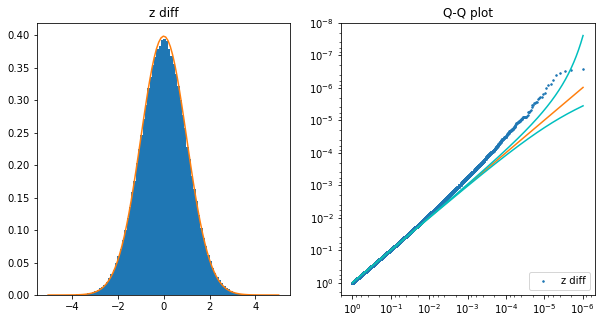

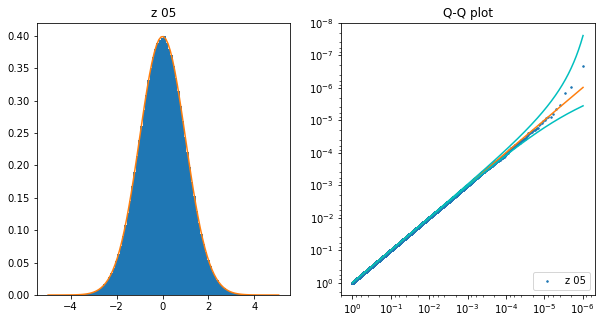

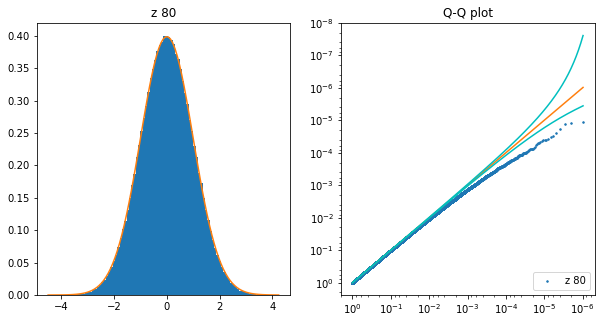

In [26]:
for wth in ['diff', '05', '80']:
    z_distribution_plot(zstats[wth], 'z ' + wth)

#### Look for bias in the random effect variance

In [32]:
for wth, hat_tau in hat_taus.items():
    print('Mean hat tau2 (over ' + str(nreal) + ' realisations) for ' + wth + ' = ' + 
          str(np.mean(hat_tau)) + ' / True tau2=' + str(tau2))

Mean hat tau2 (over 1026000 realisations) for 05 = 1.00886902299 / True tau2=1
Mean hat tau2 (over 1026000 realisations) for 10 = 1.02798506531 / True tau2=1
Mean hat tau2 (over 1026000 realisations) for 20 = 1.08181257246 / True tau2=1
Mean hat tau2 (over 1026000 realisations) for 40 = 1.22330697413 / True tau2=1
Mean hat tau2 (over 1026000 realisations) for 80 = 1.56740477013 / True tau2=1
Mean hat tau2 (over 1026000 realisations) for diff = 1.07518656485 / True tau2=1


The random effect variance is possibly positively biased.

In [35]:
for wth, meta_varcope in meta_varcopes.items():
    print('Mean meta-analytic varcope (over ' + str(nreal) + ' realisations) for ' + wth + ' = ' + 
          str(np.mean(meta_varcope)) + ' / True varcope=' + str(cope_th_var[wth]))

Mean meta-analytic varcope (over 1026000 realisations) for 05 = 0.0501427051832 / True varcope=0.05
Mean meta-analytic varcope (over 1026000 realisations) for 10 = 0.0604302613453 / True varcope=0.06
Mean meta-analytic varcope (over 1026000 realisations) for 20 = 0.0812676592655 / True varcope=0.08
Mean meta-analytic varcope (over 1026000 realisations) for 40 = 0.123792171826 / True varcope=0.12
Mean meta-analytic varcope (over 1026000 realisations) for 80 = 0.210882681754 / True varcope=0.2
Mean meta-analytic varcope (over 1026000 realisations) for diff = 0.0809958537712 / True varcope=0.08


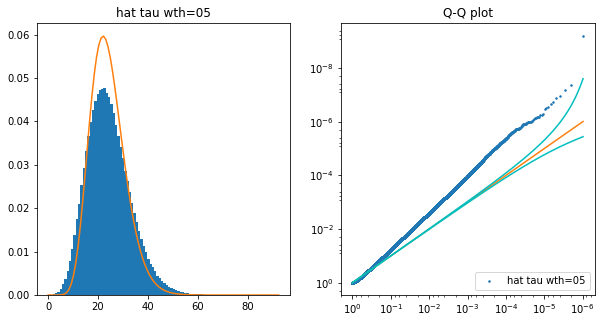

In [ ]:
for wth, hat_tau in hat_taus.items():
    chi2_distribution_plot(hat_tau/(tau2/dof), 'hat tau wth=' + wth, dof)

#### Compare cope to theoretical distribution

With MFX GLM under the null we have
```
cope ~ N(0, 1/sum(\kappa_i)) with \kappa_i = 1/(\tau^2 + \sigma_i^2)
```
i.e.:

```
cope_05 ~ N(0, 1.25/kstudies)
cope_10 ~ N(0, 1.50/kstudies)
cope_20 ~ N(0, 2/kstudies)
cope_40 ~ N(0, 3/kstudies)
cope_80 ~ N(0, 5/kstudies)

cope_diff ~ N(0, 1/(1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5))
```

##### Theoretical distribution of meta-analysic copes under H0



In [33]:
tau2 = 1
kstudies = 25
cope_th_var = dict()

def get_mfx_th_variance(tau2, sigma2_i):
    sigma2_i_ratios = [1/(tau2 + x) for x in sigma2_i]
    th_var_diff = 1/sum(sigma2_i_ratios)
    return(th_var_diff)

# From os.path.join(wth_n20['diff'], os.pardir, 'simu.mat') we see:
wth_sigma_a = [1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16]
sigma2_i = [x * 0.25 for x in wth_sigma_a]
cope_th_var['diff'] = get_mfx_th_variance(tau2, sigma2_i)
print(cope_th_var['diff'])

# Test calculation with constant within-study variance (sanity check)
sigma2_i = [x*0.25 for x in np.ones(kstudies)]
cope_th_var['05'] = get_mfx_th_variance(tau2, sigma2_i)

if np.isclose(get_mfx_th_variance(tau2, sigma2_i),(tau2+0.25)/kstudies):
    print('Sanity check succeded')
else:
    print('Sanity check failed!')
    print('th_var_cope_05=' + str(get_mfx_th_variance(tau2, sigma2_i)))
    print('th_var_cope_05=' + str((tau2+0.25)/kstudies))
    
cope_th_var['10'] = get_mfx_th_variance(tau2, [x*0.5 for x in np.ones(kstudies)])
cope_th_var['20'] = get_mfx_th_variance(tau2, [x*1 for x in np.ones(kstudies)])
cope_th_var['40'] = get_mfx_th_variance(tau2, [x*2 for x in np.ones(kstudies)])
cope_th_var['80'] = get_mfx_th_variance(tau2, [x*4 for x in np.ones(kstudies)])

0.08
Sanity check succeded


In [9]:
for [wth, r], folder in wth_n20.items():
    data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'cope1.nii.gz')).get_data().flatten()
    meta_copes[wth] = np.append(meta_copes[wth], data_array)

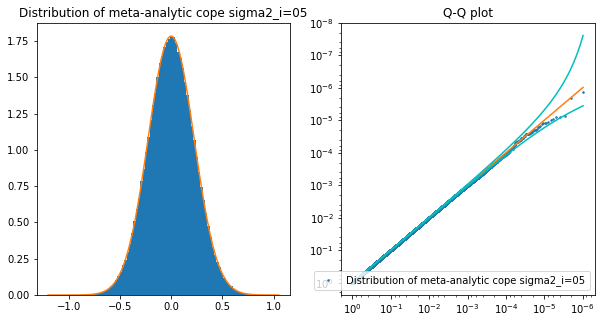

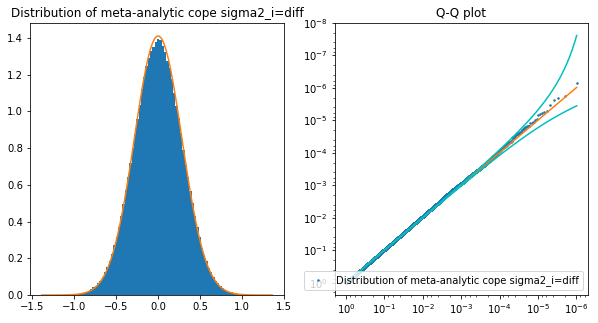

In [10]:
for wth in ['05', 'diff']:
    z_distribution_plot(
        meta_copes[wth], # cope to display
        'Distribution of meta-analytic cope sigma2_i=' + wth, # Title
        0, np.sqrt(cope_th_var[wth]) # Parameters of the theoretical Normal distribution
    )

Meta-analysic cope created with MFX GLM on varying within-study variance follows the theoretical distribution.


In [11]:
    
for wth in ['05', '80', 'diff']:
    chi2_distribution_plot(
        meta_varcopes[wth]*dof/(cope_th_var[wth]), # varcope to display scaled by sigma2/dof
        'Distribution of meta-analytic varcope sigma2_i=' + wth, 
        dof # Parameters of the theoretical Chi2 distribution
    )

KeyError: '05'

In [13]:
meta_varcopes

{('05', 1): array([ 0.0423628 ,  0.03731718,  0.06785032, ...,  0.04898507,
         0.06010117,  0.04092888], dtype=float32),
 ('05', 2): array([ 0.03659929,  0.0352892 ,  0.04709229, ...,  0.04252673,
         0.04294324,  0.03783919], dtype=float32),
 ('05', 3): array([ 0.0430828 ,  0.06652147,  0.02157914, ...,  0.02839077,
         0.02649793,  0.06619159], dtype=float32),
 ('05', 4): array([ 0.05300361,  0.047877  ,  0.03249537, ...,  0.06605698,
         0.09833832,  0.05451756], dtype=float32),
 ('05', 5): array([ 0.04367306,  0.0782554 ,  0.04709417, ...,  0.0701615 ,
         0.04847031,  0.03899212], dtype=float32),
 ('05', 6): array([ 0.06092361,  0.03163786,  0.03568249, ...,  0.0366665 ,
         0.03123496,  0.04934632], dtype=float32),
 ('05', 7): array([ 0.04136083,  0.05471981,  0.0338598 , ...,  0.04243327,
         0.02833662,  0.04724729], dtype=float32),
 ('05', 8): array([ 0.04580865,  0.06926668,  0.04248617, ...,  0.03929556,
         0.05901126,  0.04224487], 

Meta-analysic varcopes created with MFX GLM:
 - within-study variance = 5 is valid (almost invalid)
 - within-study variance = 80 is invalid in places (but valid at the tail)
 - varying within-study variance invalid thoughout.


In [ ]:
scipy.stats.chi2.fit(meta_varcopes['05']*dof/(cope_th_var['05']), floc=0, fscale=1)

In [ ]:
scipy.stats.chi2.fit(meta_varcopes['diff']*dof/(cope_th_var['diff']), floc=0, fscale=1)

In [ ]:
scipy.stats.chi2.fit(meta_varcopes['80']*dof/(cope_th_var['05']), floc=0, fscale=1)